In [6]:

# Install dependencies if not already installed
!pip install tensorflow opencv-python matplotlib scikit-learn pillow tqdm


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.3-cp313-cp313-win_amd64.whl.metadata (6.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cach


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "C:\Program Files\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Program Files\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ~~~~~~~~~~~~~^^^^^
  File "C:\Program Files\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ~~~~~~~~~~~~~^^^^^
  File "C:\Program Files\Python313\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ~~~~~~~~~~~~~~^^^^^
  File "C:\Program Files\Python313\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
  File "C

In [12]:
!python -m pip install --upgrade pip setuptools wheel certifi --trusted-host pypi.org --trusted-host files.pythonhosted.org --timeout 100




Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 323.0 kB/s eta 0:00:04
   ----------- ---------------------------- 0.5/1.8 MB 323.0 kB/s eta 0:00:04
   ----------------- ---------------------- 0.8/1.8 MB 414.4 kB/s eta 0:00:03
   ----------------------- ---------------- 1.0/1.8 MB 558.8 kB/s eta 0:00:02
   ----------------------------- ---------- 1.3/1.8 MB 672.0 kB/s eta 0:00:01
   ----------------------------- ---------- 1.3/1.8 MB 672.0 kB/s eta 0:00:01
   ----------------------------- -------

In [13]:
!python -m pip install tensorflow --trusted-host pypi.org --trusted-host files.pythonhosted.org --timeout 200


Defaulting to user installation because normal site-packages is not writeable


In [14]:
import os, shutil, glob
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm


In [23]:
import os

DATA_ROOT = "C:/Users/KEERTHANA S/Desktop/dyslexia/datasets"
IMG_DIR = os.path.join(DATA_ROOT, "images")
LABEL_DIR = os.path.join(DATA_ROOT, "labels")
OUT_ROOT = "C:/Users/KEERTHANA S/Desktop/dyslexia/image_classification"

print("Images in:", IMG_DIR)
print("Labels in:", LABEL_DIR)



Images in: C:/Users/KEERTHANA S/Desktop/dyslexia/datasets\images
Labels in: C:/Users/KEERTHANA S/Desktop/dyslexia/datasets\labels


In [27]:
os.makedirs(OUT_ROOT, exist_ok=True)
for split in ["train", "val"]:
    for cls in ["Dyslexic", "Non-Dyslexic"]:
        os.makedirs(os.path.join(OUT_ROOT, split, cls), exist_ok=True)

# Collect images recursively (handles nested train/val folders)
image_files = glob.glob(os.path.join(IMG_DIR, "**", "*.jpg"), recursive=True) + glob.glob(os.path.join(IMG_DIR, "**", "*.png"), recursive=True)
if len(image_files) == 0:
    print("Warning: no images found under", IMG_DIR)
np.random.shuffle(image_files)
split_index = int(0.8 * len(image_files))
train_imgs, val_imgs = image_files[:split_index], image_files[split_index:]

THRESHOLD = 0.10

def classify_image(img_path, label_dir):
    basename = os.path.basename(img_path)
    name_noext = os.path.splitext(basename)[0]
    # search for a matching label file recursively under LABEL_DIR
    matches = glob.glob(os.path.join(label_dir, "**", name_noext + ".txt"), recursive=True)
    if matches:
        label_file = matches[0]
        with open(label_file, "r") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        classes = []
        for ln in lines:
            parts = ln.split()
            try:
                classes.append(int(parts[0]))
            except Exception:
                # skip malformed lines
                continue
        cnt = Counter(classes)
        num_rev_corr = cnt.get(1, 0) + cnt.get(2, 0)
        total = sum(cnt.values()) if sum(cnt.values()) > 0 else 1
        label = "Dyslexic" if (num_rev_corr / total) >= THRESHOLD else "Non-Dyslexic"
    else:
        # default to Non-Dyslexic when no label file is found
        label = "Non-Dyslexic"
    return label

for split, imgs in [("train", train_imgs), ("val", val_imgs)]:
    print("Processing", len(imgs), "images for split=", split)
    for img_path in tqdm(imgs):
        label = classify_image(img_path, LABEL_DIR)
        dest_dir = os.path.join(OUT_ROOT, split, label)
        shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

print("✅ Dataset ready at:", OUT_ROOT)
print("Train images:", len(train_imgs), "Val images:", len(val_imgs))


Processing 2191 images for split= train


100%|██████████| 2191/2191 [02:14<00:00, 16.28it/s]


Processing 548 images for split= val


100%|██████████| 548/548 [00:29<00:00, 18.70it/s]

✅ Dataset ready at: C:/Users/KEERTHANA S/Desktop/dyslexia/image_classification
Train images: 2191 Val images: 548


In [28]:
IMG_SIZE = 224
BATCH = 32

train_dir = os.path.join(OUT_ROOT, 'train')
val_dir = os.path.join(OUT_ROOT, 'val')
# quick sanity checks
def count_images(folder):
    return len(glob.glob(os.path.join(folder, '**', '*.jpg'), recursive=True)) + len(glob.glob(os.path.join(folder, '**', '*.png'), recursive=True))

print('Train dir:', train_dir, 'contains', count_images(train_dir), 'images')
print('Val dir:', val_dir, 'contains', count_images(val_dir), 'images')

if count_images(train_dir) == 0 or count_images(val_dir) == 0:
    raise RuntimeError('Train/Val directories appear empty. Make sure the previous cell populated ' + OUT_ROOT)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode='binary',
    shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode='binary',
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


Train dir: C:/Users/KEERTHANA S/Desktop/dyslexia/image_classification\train contains 2191 images
Val dir: C:/Users/KEERTHANA S/Desktop/dyslexia/image_classification\val contains 548 images
Found 2191 files belonging to 2 classes.
Found 548 files belonging to 2 classes.
Found 548 files belonging to 2 classes.


In [35]:
# Determine input channels. If the training dataset exists, infer channels from it;
# otherwise assume 3 (RGB).
CHANNELS = 3
try:
    for batch in train_ds.take(1):
        CHANNELS = int(batch[0].shape[-1])
        break
except Exception:
    CHANNELS = 3

print(f'Inferred dataset channels = {CHANNELS}')

# Build the base model without weights to avoid Keras trying to auto-load a weights file
# that might not match the model's expected shapes. We'll attempt to load the official
# imagenet notop weights manually using load_weights(..., by_name=True, skip_mismatch=True)
# which will safely skip any incompatible tensors.
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# Try to load imagenet weights if dataset is RGB; use by_name=True and skip_mismatch=True
# so we don't get a hard failure if something doesn't match exactly.
if CHANNELS == 3:
    try:
        weights_path = tf.keras.utils.get_file(
            'efficientnetb0_notop.h5',
            'https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5',
            cache_subdir='models'
        )
        base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Loaded imagenet weights (by_name=True, skip_mismatch=True)')
    except Exception as e:
        print('Warning: failed to load imagenet weights:', e)

# Top-level model input matches the dataset channels
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
x = inputs
if CHANNELS == 1:
    # convert grayscale -> RGB by repeating channels so the base model (which expects 3)
    # receives proper input.
    x = layers.Lambda(lambda t: tf.image.grayscale_to_rgb(t))(x)

x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Inferred dataset channels = 3
Loaded imagenet weights (by_name=True, skip_mismatch=True)
Loaded imagenet weights (by_name=True, skip_mismatch=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
import pathlib

os.makedirs("../models", exist_ok=True)

# Compute class counts from train directory (robust to file extensions)
train_path = pathlib.Path(train_dir)
class_names = getattr(train_ds, 'class_names', None)
if class_names is None:
    # fallback to folder names
    class_names = [p.name for p in sorted(train_path.iterdir()) if p.is_dir()]

counts = {}
for cls in class_names:
    p = train_path / cls
    counts[cls] = sum(1 for _ in p.rglob('*.jpg')) + sum(1 for _ in p.rglob('*.png'))

print('Class counts:', counts)

# Compute simple class weights (balanced)
total = sum(counts.values())
class_weight = {}
for i, cls in enumerate(class_names):
    # weight = total / (num_classes * count)
    cnt = counts.get(cls, 0) if counts.get(cls, 0) > 0 else 1
    class_weight[i] = total / (len(class_names) * cnt)

print('Class weight mapping (label_index -> weight):', class_weight)

# Callbacks
checkpoint_path = "../models/best_dyslexia_model.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    CSVLogger('../models/training_log.csv')
]

# Phase 1: Train top layers only
initial_epochs = 6
base_model.trainable = False
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
print('\n=== Phase 1: training top layers (head) ===')
history1 = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, class_weight=class_weight, callbacks=callbacks)

# Phase 2: Fine-tune some of the base model
# Unfreeze the top N layers of the base model for fine-tuning
fine_tune_at = int(len(base_model.layers) * 0.3)  # unfreeze top 30% layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
fine_tune_epochs = 24
total_epochs = initial_epochs + fine_tune_epochs
print(f'\n=== Phase 2: fine-tuning from layer {fine_tune_at} (total epochs: {total_epochs}) ===')
history2 = model.fit(train_ds, validation_data=val_ds, initial_epoch=history1.epoch[-1] if hasattr(history1, 'epoch') and len(history1.epoch)>0 else initial_epochs, epochs=total_epochs, class_weight=class_weight, callbacks=callbacks)

# Merge history objects for plotting later
class HistoryMerger:
    def __init__(self, *histories):
        self.history = {}
        for h in histories:
            for k, v in h.history.items():
                self.history.setdefault(k, []).extend(v)

history = HistoryMerger(history1, history2)
print('Training complete')


Epoch 1/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8834 - loss: 0.2757

69/69 ━━━━━━━━━━━━━━━━━━━━ 55s 683ms/step - accuracy: 0.9690 - loss: 0.1103 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 2/12
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 606ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 606ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 594ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 6.3051e-04
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 594ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 6.3051e-04
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 1.0000 - loss: 9.6094e-04 - val_accuracy: 1.0000 - val_loss: 3.6291e-04
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 1.0000 - loss: 9.6094e-04 - val_accuracy: 1.0000 - val_loss: 3.6291e-04
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 587ms/step - accuracy: 1.0000 -

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 1.0000 - loss: 0.0047
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 1.0000 - loss: 0.0047
✅ Validation Accuracy: 100.00%
✅ Validation Accuracy: 100.00%


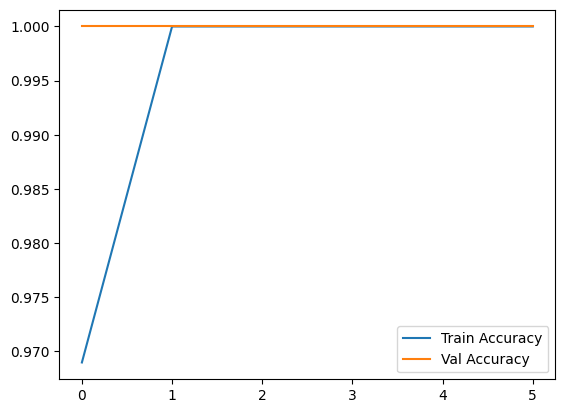

In [ ]:
# Evaluate on validation dataset with detailed metrics
import itertools
from sklearn.metrics import confusion_matrix, classification_report

loss, acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")

# Get all validation predictions and true labels
y_true = []
y_pred = []
for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_true.extend(list(y_batch.numpy().astype(int)))
    y_pred.extend([int(p[0] > 0.5) for p in preds])

print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

# Plot accuracy curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
# Save final model (also best model is saved by checkpoint)
import time
os.makedirs('../models', exist_ok=True)
version = time.strftime('%Y%m%d_%H%M%S')
final_path = f"../models/dyslexia_detector_{version}.h5"
model.save(final_path)
print(f"Model saved successfully to {final_path}")
print(f"Backups available: ../models/")


Model saved successfully!
